In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import random
from itertools import permutations, combinations, combinations_with_replacement
from rich.progress import track
from rich.progress import Progress


In [2]:


def gen_momentum_vectors(N):
    #generate random 2d, unit vectors ---> (x, z)
    x_vals = np.random.uniform(-1, 1, size = N)
    z_vals = np.random.uniform(-1, 1, size = N)
    
    J_plus = np.asarray([np.asarray([x, z]).reshape(2,1) for x, z in zip(x_vals, z_vals)])
    J_minus = np.asarray([-1*Jp for Jp in J_plus])
    
    return [J_plus, J_minus]


vecs = gen_momentum_vectors(10)



In [3]:
def gen_measurement_vector(theta):
    #generate a measurement vector --> (x,z)
    #functions assume radians
    components = np.array(([np.sin(theta),np.cos(theta)]))
    magnitude = math.sqrt(sum(pow(element, 2) for element in components))
    unit_vector = components/magnitude
    return unit_vector



gen_measurement_vector(np.pi/4)

array([0.70710678, 0.70710678])

In [4]:

def check_thetas(thetas, val):
    mask = [theta == val for theta in thetas]
    return any(mask)



def experiment(number_of_momentum_vectors, theta_11 = None, theta_12 = None, theta_21 = None, theta_22 = None):
    thetas = [theta_11, theta_12, theta_21, theta_22]
    
    if check_thetas(thetas, None):
        raise ValueError(f"Thetas cannone be None. Thetas: {thetas}")

    #creates 4 experiement vectors from input theta
    alpha_1 = gen_measurement_vector(theta_11)
    alpha_2 = gen_measurement_vector(theta_12)
    beta_1 = gen_measurement_vector(theta_21)
    beta_2 = gen_measurement_vector(theta_22)
    
    #used to calcuate correlators 
    alpha_1_beta_1 = [] 
    alpha_2_beta_1 = [] 
    alpha_1_beta_2 = [] 
    alpha_2_beta_2 = []
    
    #creates N momentum vectors
    momentum_vectors = gen_momentum_vectors(number_of_momentum_vectors)
   
    #does experiment
    for up_momentum_vectors in momentum_vectors[0]:
        #randomly chooses an alpha and a beta
        #print(np.random.uniform(0, 1, size = 1)[0])
        counter_alpha = 0 
        counter_beta = 0
        if random.randint(1, 2)  == 1:
            measurement_1 = alpha_1
            counter_alpha += 1
        else: 
            measurement_1 = alpha_2
            counter_alpha += 2
            
        if random.randint(1, 2) == 1:
            measurement_2 = beta_1
            counter_beta += 1
        else: 
            measurement_2 = beta_2
            counter_beta += 2
        #normalize momentum vectors
        components = np.array(up_momentum_vectors)
        magnitude = math.sqrt(sum(pow(element, 2) for element in components))
        unit_vector = components/magnitude
        
       
        
        #measurements
        a_alpha_i = np.sign(np.dot(measurement_1,unit_vector))
        b_beta_i = -np.sign(np.dot(measurement_2,unit_vector))
        measurement = a_alpha_i[0]*b_beta_i[0]
        
        
        #sorts measruements into 4 correlators to later calculate CHSH correlator
        
        #problem here alpha_2_beta_1 array not populating
        if counter_alpha == 1 and counter_beta == 1:
            alpha_1_beta_1.append(measurement)
        elif counter_alpha == 1 and counter_beta == 2: 
            alpha_1_beta_2.append(measurement)
        elif counter_alpha == 2 and counter_beta == 1:
            alpha_2_beta_1.append(measurement)
        elif counter_alpha == 2 and counter_beta == 2:
            alpha_2_beta_2.append(measurement)
        
    #print(alpha_1_beta_1,alpha_1_beta_2,alpha_2_beta_1,alpha_2_beta_2)
        
    
    correlator_11 = np.sum(alpha_1_beta_1)/len(alpha_1_beta_1)
    correlator_12 = np.sum(alpha_1_beta_2)/len(alpha_1_beta_2)
    correlator_21 = np.sum(alpha_2_beta_1)/len(alpha_2_beta_1) 
    correlator_22 = np.sum(alpha_2_beta_2)/len(alpha_2_beta_2)
    
    S_classic = correlator_11 + correlator_12 + correlator_21 - correlator_22    
    
    S_quantum = -np.cos(theta_11-theta_21)+np.cos(theta_11-theta_22)-np.cos(theta_12-theta_21)-np.cos(theta_12-theta_22)
        
    
    return S_classic, S_quantum

y_axis_classical = []
y_axis_quantum = []
x_axis = []
number_of_experiments = 100
angle_divisions = 100
for angle in np.linspace(0,2*np.pi,angle_divisions):
    
    angles = {
    "theta_11" : 0*angle,
    "theta_12" : 2*angle,
    "theta_21" :   angle,
    "theta_22" : 3*angle
    }
    
    #print(angles)
    
    
    classic, quantum= experiment(number_of_experiments, **angles)
    #print(classic,quantum)
    #print("Correlator: ", experiment(angle,2000), "Angle(in radians): ", angle)
    x_axis.append(angle)
    y_axis_classical.append(classic)
    y_axis_quantum.append(quantum)
    #print(experiment(angle,number_of_experiments), angle)
        


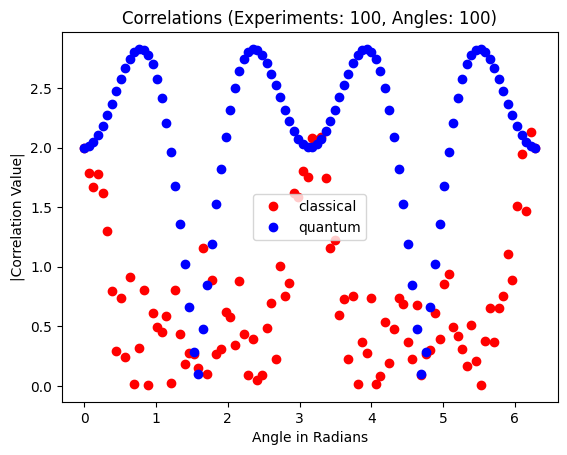

In [5]:
plt.xlabel('Angle in Radians')
plt.ylabel('|Correlation Value|')
plt.title(f'Correlations (Experiments: {number_of_experiments}, Angles: {angle_divisions})')
plt.plot(x_axis,np.abs(y_axis_classical),'ro')
plt.plot(x_axis,np.abs(y_axis_quantum),'bo')
plt.legend(["classical", "quantum"])

In [49]:


def get_theta_ratios(max_ratio, divisions):
    """Generates a list of theta ratios between 0 and max_ratio devided evenly by divisions

    Args:
        max_ratio (int): maximum integer rati0
        divisions (int): number of spaced divisions between 0 and max_ratio

    Returns:
        list: list of angle ratios, ie) [0, 0.25, 0.5, 1].  will eventually correspond to the arguments: [0*angle, 0.25*angle, 0.5*angle, 1*angle] later in the code
    """
    
    vals = [max_ratio*i*(1/divisions)  for i in range(divisions + 1)]
    vals = vals + [i for i in range(1, max_ratio)]
    
    return sorted(list(set(vals)))


def gen_theta_ratio_permutations(thetas_ratios):
    """Generates all posible permutations of the angles above using the combinations len(thetas ratios) choose 4, since we need 4 angles for each experiment

    Args:
        thetas_ratios (list): return value of get_theta_ratios

    Returns:
        list of lists: list of each permutation of thetas_ratios
    """
    
    comb_vals = list(combinations_with_replacement(thetas_ratios, r = 4))
    all_perms = []
    for i in range(len(comb_vals)):
        comb = list(comb_vals[i])
        perms = list(set(permutations(comb)))
        all_perms += perms
    
    return list(set(all_perms))



def gen_experiment_set(theta_ratios, angle_divisions = 100, number_of_experiments = 100):
    y_axis_classical = []
    y_axis_quantum = []
    x_axis = []
    
    ret = {}
    ret.update(theta_ratios)

    for angle in np.linspace(0,2*np.pi,angle_divisions):
        
        
        angles = {
        "theta_11" : theta_ratios["theta_11"]*angle,
        "theta_12" : theta_ratios["theta_12"]*angle,
        "theta_21" : theta_ratios["theta_21"]*angle,
        "theta_22" : theta_ratios["theta_22"]*angle
        }
        
    
        
        #print(angles)
        
        
        classic, quantum = experiment(number_of_experiments, **angles)
        #print(classic,quantum)
        #print("Correlator: ", experiment(angle,2000), "Angle(in radians): ", angle)
        
        #x_axis.append(angle)
        #y_axis_classical.append(classic)
        #y_axis_quantum.append(quantum)
        
        x_axis = np.append(x_axis, [angle])
        y_axis_classical = np.append(y_axis_classical, [abs(classic)])
        y_axis_quantum = np.append(y_axis_quantum, [abs(quantum)])
        #print(experiment(angle,number_of_experiments), angle)
        
        quantum_max_index = np.where(y_axis_quantum == np.max(y_axis_quantum))[0][0]
        classical_max_index = np.where(y_axis_classical == np.max(y_axis_classical))[0][0]
        
    results = {
        "classical_max_angle": np.rad2deg(y_axis_classical[classical_max_index]),
        "quantum_max_angle": np.rad2deg(y_axis_quantum[quantum_max_index]),
        "classical_max_value": y_axis_classical[classical_max_index],
        "quantum_max_value": y_axis_quantum[quantum_max_index]
    }
    
    ret.update(results)
        
    return ret


def gen_all_experiment_sets(max_ratio, divisions, angle_divisions = 100, number_of_experiments = 100, downsample = None):
    
    thetas_ratios = get_theta_ratios(max_ratio, divisions)
    all_perms = gen_theta_ratio_permutations(thetas_ratios)
    
    if downsample:
        all_perms = all_perms[:downsample]
    
    all_exp_sets = []
    
    #True if downsample is given as an argument, else False
    break_flag = False if not downsample else True
    
    with Progress() as progress:
    
    
        task1 = progress.add_task("[green]Processing...", total=len(all_perms))
        
        
        for i in range(len(all_perms)):
            progress.update(task1, advance = 1)
            perm = all_perms[i]
     
            #creating dict of theta ratios
            perm_dict = {
                "theta_11" : all_perms[i][0],
                "theta_12" : all_perms[i][1],
                "theta_21" : all_perms[i][2],
                "theta_22" : all_perms[i][3]
                }
            
            a_set = gen_experiment_set(theta_ratios = perm_dict, angle_divisions = angle_divisions, number_of_experiments = number_of_experiments)
            
            all_exp_sets.append(a_set)
            
           
            
            
            
    print("Done.")
    return pd.DataFrame(all_exp_sets, index = list(range(len(all_exp_sets))))
    
    
    




perms = gen_all_experiment_sets(3, 4, downsample=None)


perms.to_csv("Output.csv")
        
    
        



Output()

Done.


In [66]:
df = pd.read_csv("Output.csv")
df.head(5)


,theta_11,theta_12,theta_21,theta_22,classical_max_angle,quantum_max_angle,classical_max_value,quantum_max_value
0,0.00,0.75,0.00,3.0,155.696660,135.563270,2.717419,2.366025
1,2.25,3.00,2.25,3.0,114.591559,114.591559,2.000000,2.000000
2,1.00,0.00,0.75,3.0,149.678785,152.805694,2.612388,2.666962
3,2.00,0.75,2.00,3.0,163.367047,125.452808,2.851293,2.189565
4,3.00,3.00,3.00,0.0,146.912255,114.591559,2.564103,2.000000


In [72]:
#df.plot.scatter("classical_max_angle", "classical_max_value")

df[df['quantum_max_value'] == df['quantum_max_value'].max()]

,theta_11,theta_12,theta_21,theta_22,classical_max_angle,quantum_max_angle,classical_max_value,quantum_max_value
953,3.0,1.0,2.0,0.0,114.591559,162.041557,2.0,2.828159
2121,0.0,2.0,1.0,3.0,114.591559,162.041557,2.0,2.828159


In [74]:
#df[df['classical_max_value'] == df['classical_max_value'].max()]
df[df['classical_max_value'] > 2]

,theta_11,theta_12,theta_21,theta_22,classical_max_angle,quantum_max_angle,classical_max_value,quantum_max_value
0,0.00,0.75,0.00,3.00,155.696660,135.563270,2.717419,2.366025
2,1.00,0.00,0.75,3.00,149.678785,152.805694,2.612388,2.666962
3,2.00,0.75,2.00,3.00,163.367047,125.452808,2.851293,2.189565
4,3.00,3.00,3.00,0.00,146.912255,114.591559,2.564103,2.000000
5,3.00,3.00,3.00,0.75,151.109748,114.591559,2.637363,2.000000
...,...,...,...,...,...,...,...,...
2396,0.75,1.00,3.00,0.75,152.656116,129.211742,2.664352,2.255170
2397,2.00,0.00,1.00,2.00,157.117760,143.239449,2.742222,2.500000
2398,0.00,0.00,0.00,3.00,167.794783,114.591559,2.928571,2.000000
2399,2.00,0.00,1.00,2.25,166.263678,161.192413,2.901849,2.813338
